<a href="https://colab.research.google.com/github/ArjunNarayan2066/Test/blob/master/A2Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
!pip install ipympl
import ipympl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
# make it easier to understand by importing the required libraries within keras
from tensorflow.keras.layers import Dense, Flatten

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

np.random.seed(1)
np.set_printoptions(suppress=True)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Fetch the raw data once from the file
rawdata = np.genfromtxt('diabetes.csv', delimiter=',')
print(rawdata.shape)
data = rawdata[1:]
fields = data[:,:-1]
labels = data[:,-1].astype(np.int)
print(fields.shape)
print(labels.shape)


(769, 9)
(768, 8)
(768,)


In [4]:
# # Preprocess data into 80% of both 1 & 0 cases
# # Normalize data to between 1 & 0 in each field
# fields_max = fields.max(axis=0)
# norm_fields = fields / fields_max

# training_split = 0.8

# # Split into training & testing data
# label1_idx = np.where(labels == 1)[0]
# label0_idx = np.where(labels == 0)[0]
# label1_count = len(label1_idx)
# label0_count = len(label0_idx)
# train_size_1 = int(label1_count*training_split)
# train_size_0 = int(label0_count*training_split)

# # Fetch indices of training & testing data
# train_idx_1 = label1_idx[:train_size_1]
# train_idx_0 = label0_idx[:train_size_0]
# test_idx_1 = label1_idx[train_size_1:]
# test_idx_0 = label0_idx[train_size_0:]

# # Combine 1 & 0 cases to single array of indices
# train_idx = np.concatenate((train_idx_1, train_idx_0))
# test_idx = np.concatenate((test_idx_1, test_idx_0))

# # Final normalized & separated training & testing data
# train_data = norm_fields[train_idx]
# train_labels = labels[train_idx]
# test_data = norm_fields[test_idx]
# test_labels = labels[test_idx]

# print(train_data.shape)
# print(test_labels.shape)

In [5]:
# Normalize the data
norm_fields = (fields - fields.min(axis=0)) / (fields.max(axis=0) - fields.min(axis=0))

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)

# Split the data into training and testing
train_fields, test_fields, train_labels, test_labels = train_test_split(norm_fields, labels, test_size=0.20)

train_labels_enc = encoder.fit_transform(train_labels.reshape(-1,1))
test_labels_enc = encoder.fit_transform(test_labels.reshape(-1,1))

# print(train_labels)

print("Sample train data: {}".format(train_labels_enc[:3]))
print("Sample train labels: {}".format(test_labels_enc[:3]))

Sample train data: [[0. 1.]
 [0. 1.]
 [1. 0.]]
Sample train labels: [[1. 0.]
 [1. 0.]
 [1. 0.]]


In [18]:
# General training code for Question 3 functions

val_err_callback = keras.callbacks.EarlyStopping(monitor='val_loss', baseline=0.06, patience=100, mode="min") 
callbacks = [val_err_callback]

def train(model,K, lr = 0.005):
    best_history = None
    best_loss = 1e6 # Something big
    fig_count = 0
    rolls = [len(s) for s in np.array_split(np.arange(len(labels)), K)]
    
    with tf.device('/device:GPU:0'):
        folded_fields = np.copy(train_fields)
        folded_labels = np.copy(train_labels_enc)

        # Apply K-fold cross validation
        val_split = 1.0/K
        for k in range(K):               
            model.compile(loss='categorical_crossentropy',  metrics=['accuracy'], 
                            optimizer=keras.optimizers.Adam(learning_rate=lr))
                       
            h = model.fit(folded_fields, folded_labels, 
                        epochs=1000, batch_size=5, validation_split=val_split, 
                        verbose=1, callbacks=callbacks)
            # Plot Results in Real Time
            plt.figure(fig_count)
            fig_count += 1
            plt.plot(h.history['loss'], 'b')
            plt.plot(h.history['val_loss'], 'r')
            plt.legend(['Training Loss', 'Validation Loss'])

            # Save the current values
            print("      Fold {} -- Train Err {} -- Val Err {}".format(k, h.history['loss'][-1], h.history['val_loss'][-1]))
            # Cycle the dataset, move the next 10% into the last spot to then cross-validate with the next fold
            folded_fields = np.roll(folded_fields, rolls[k])
            folded_labels = np.roll(folded_labels, rolls[k])

            if h.history['val_loss'][-1] < best_loss:
                best_loss = h.history['val_loss'][-1]
                best_history = h
    
    print("Best Loss: {}".format(best_loss))
    return best_history


### Model 1

Epoch 1/1000
99/99 [==============================] - 1s 5ms/step - loss: 0.6875 - accuracy: 0.6140 - val_loss: 0.6811 - val_accuracy: 0.6341
Epoch 2/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6780 - val_loss: 0.6544 - val_accuracy: 0.6341
Epoch 3/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6465 - val_loss: 0.6233 - val_accuracy: 0.6341
Epoch 4/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.6163 - accuracy: 0.6597 - val_loss: 0.5723 - val_accuracy: 0.6423
Epoch 5/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.5707 - accuracy: 0.6858 - val_loss: 0.4891 - val_accuracy: 0.7642
Epoch 6/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.5479 - accuracy: 0.7212 - val_loss: 0.5370 - val_accuracy: 0.6992
Epoch 7/1000
99/99 [==============================] - 0s 3ms/step - loss: 0.5350 - accuracy: 0.7203 - val_loss: 0.5009 - val_accuracy: 0.7561
Epoch 

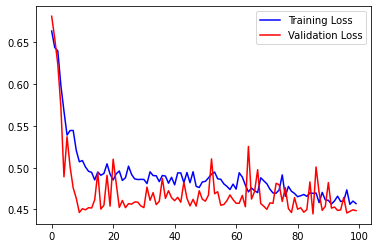

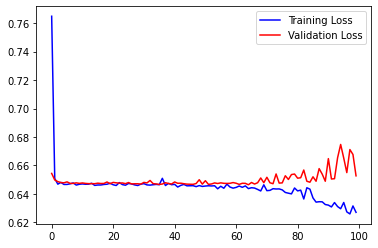

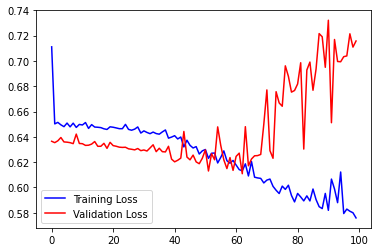

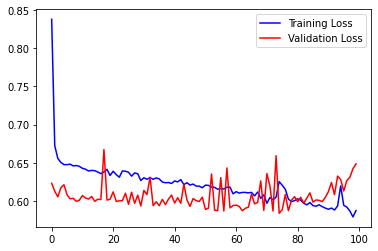

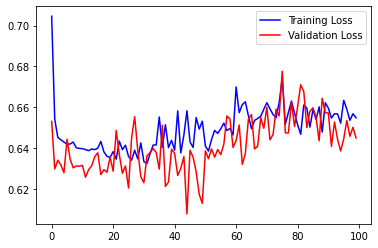

In [19]:
%%time

model_1 = keras.models.Sequential([
    Dense(60, activation='sigmoid', input_shape=(8,)),
    Dense(40, activation='sigmoid'),
    Dense(20, activation='sigmoid'),
    # Dense(1, activation='linear')
    Dense(2, activation='softmax')
])
hist = train(model_1, 5, lr=0.005)

5/5 [==============================] - 0s 3ms/step - loss: 0.9415 - accuracy: 0.4416

Test accuracy: 0.44155845046043396

Test loss:  0.9414955377578735


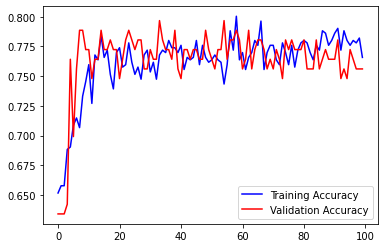

In [21]:
plt.figure(6)
plt.plot(hist.history['accuracy'], 'b')
plt.plot(hist.history['val_accuracy'], 'r')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

test_loss, test_acc = model_1.evaluate(test_fields,  test_labels_enc)
print('\nTest accuracy:', test_acc)
print('\nTest loss: ', test_loss)

### Model 2

Epoch 1/250
491/491 [==============================] - 1s 2ms/step - loss: 0.3343 - accuracy: 0.5621 - val_loss: 0.2145 - val_accuracy: 0.7561
Epoch 2/250
491/491 [==============================] - 1s 2ms/step - loss: 0.2518 - accuracy: 0.5812 - val_loss: 0.2250 - val_accuracy: 0.5447
Epoch 3/250
491/491 [==============================] - 1s 2ms/step - loss: 0.2133 - accuracy: 0.6808 - val_loss: 0.1866 - val_accuracy: 0.7886
Epoch 4/250
491/491 [==============================] - 1s 2ms/step - loss: 0.2005 - accuracy: 0.7016 - val_loss: 0.2690 - val_accuracy: 0.5447
Epoch 5/250
491/491 [==============================] - 1s 2ms/step - loss: 0.2228 - accuracy: 0.6324 - val_loss: 0.1919 - val_accuracy: 0.6748
Epoch 6/250
491/491 [==============================] - 1s 2ms/step - loss: 0.1951 - accuracy: 0.6941 - val_loss: 0.1783 - val_accuracy: 0.6829
Epoch 7/250
491/491 [==============================] - 1s 2ms/step - loss: 0.2036 - accuracy: 0.6937 - val_loss: 0.2199 - val_accuracy: 0.6179

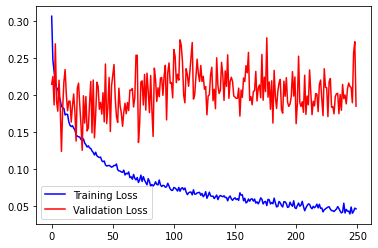

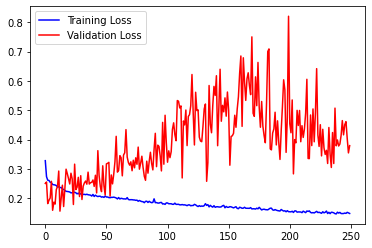

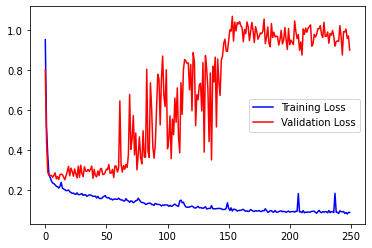

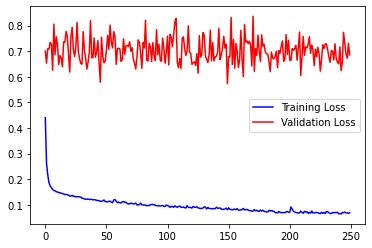

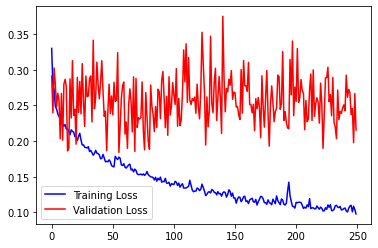

In [ ]:
%%time

model_2 = keras.models.Sequential([
    Dense(40, activation='sigmoid', input_shape=(8,)),
    Dense(20, activation='sigmoid'),
    Dense(1, activation='linear')
])
history = train(model_1, 5, 0.001)

5/5 [==============================] - 0s 3ms/step - loss: 1.7681 - accuracy: 0.4221

Test accuracy: 0.4220779240131378

Test loss:  1.768139123916626


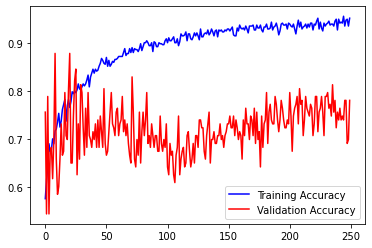

In [ ]:
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

test_loss, test_acc = model_1.evaluate(test_data,  test_labels)
print('\nTest accuracy:', test_acc)
print('\nTest loss: ', test_loss)